# Import packages

In [64]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Load Boston Housing dataset, display target prices with respect to each feature

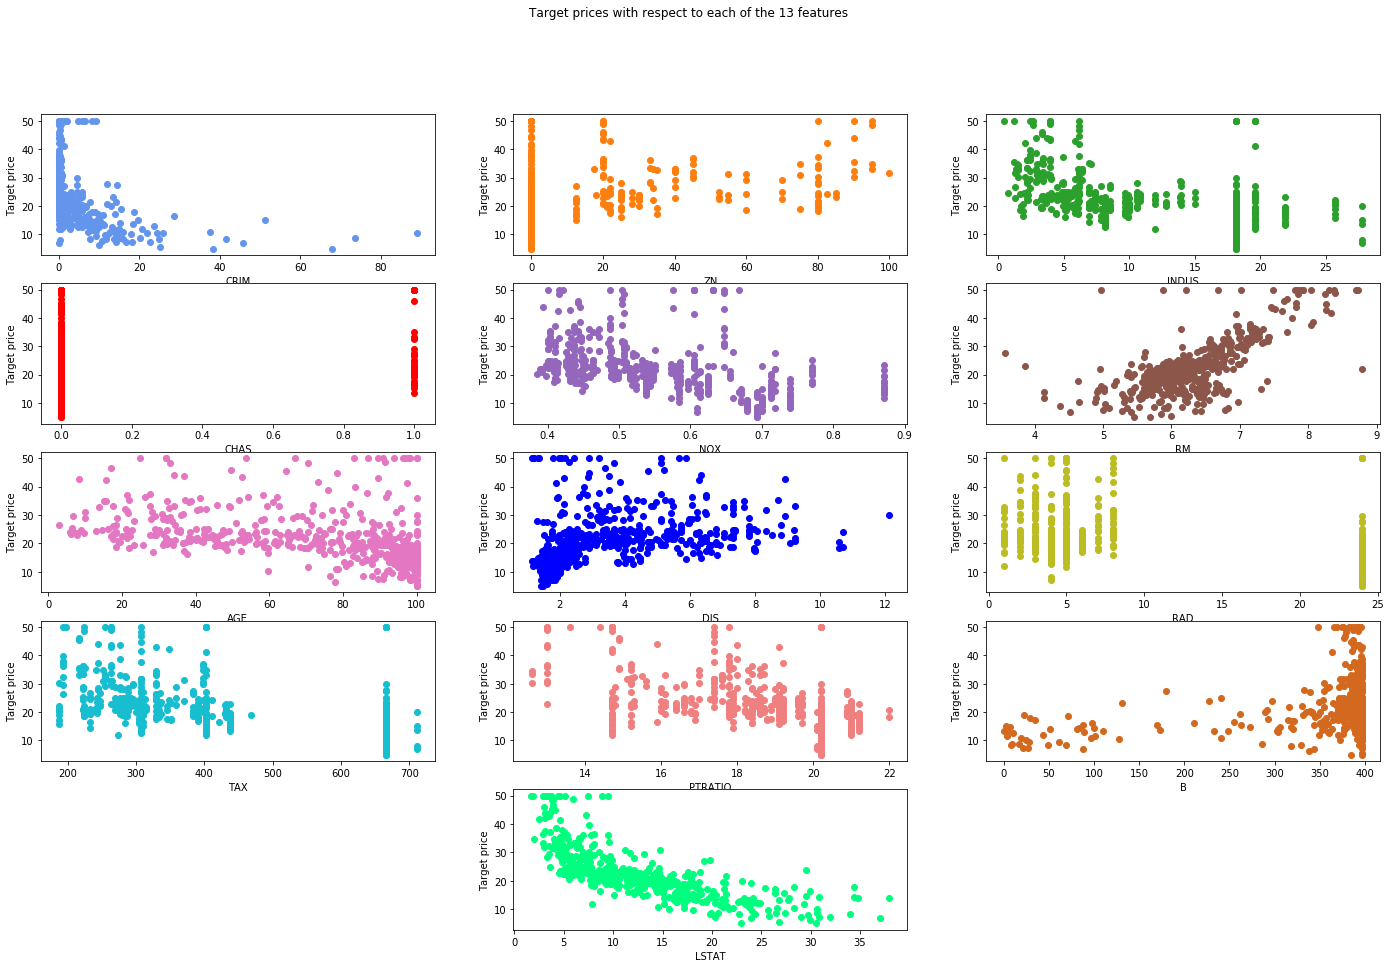

In [65]:
### Load Boston dataset (store the features in a matrix X, and the target prices in a vector Y):
boston = load_boston()
X = boston.data
Y = boston.target
# Display scatterplots of target prices with respect to each of the 13 features:
colors = ['cornflowerblue',
          'tab:orange',
          'tab:green',
          'r',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'b',
          'tab:olive',
          'tab:cyan',
          'lightcoral',
          'chocolate',
          'springgreen']
for col in range(X.shape[1]):
    plt.figure(1, figsize=(24, 15))
    if col < X.shape[1] - 1:
        plot_idx = col+1
    else:
        plot_idx = 14
    plt.subplot(5, 3, plot_idx)
    plt.scatter(X[:,col], Y, marker='o', c=colors[col])
    plt.xlabel(boston.feature_names[col])
    plt.ylabel('Target price')
plt.suptitle("Target prices with respect to each of the 13 features")
plt.show()

# Finish implementing model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation

In [66]:
### Split+shuffle X and Y into k=num_folds different folds:
def KFold_split(X, Y, num_folds, seed):
    KFold_splitter = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    X_train_folds = []
    X_val_folds = []
    Y_train_folds = []
    Y_val_folds = []
    for (kth_fold_train_idxs, kth_fold_val_idxs) in KFold_splitter.split(X, Y):
        X_train_folds.append(X[kth_fold_train_idxs])
        X_val_folds.append(X[kth_fold_val_idxs])
        Y_train_folds.append(Y[kth_fold_train_idxs])
        Y_val_folds.append(Y[kth_fold_val_idxs])
    return X_train_folds, X_val_folds, Y_train_folds, Y_val_folds

In [67]:
### Select a Ridge model on a list of hyper-parameters instances, via Kfold cross-validation:
def KFold_model_selection(X, Y, hyper_parameters_instances, num_folds, seed):
    # Extract a test set:
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
    # Extract train and validation folds:
    X_train_folds, X_val_folds, Y_train_folds, Y_val_folds = KFold_split(X_train_val, Y_train_val, num_folds, seed)
    # For each hyper-parameter instance, do KFold cross validation:
    mean_val_MSEs = []
    for hyper_parameters_instance in hyper_parameters_instances:
        print("\nNow preprocessing hyper-parameter instance", hyper_parameters_instance)
        mean_val_MSE = perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds,\
                                        hyper_parameters_instance["degree"],hyper_parameters_instance["regularization"])
        print("Mean validation MSE:", mean_val_MSE)
        mean_val_MSEs.append(mean_val_MSE)
    # The hyper-parameter instance with the smallest mean validation MSE is our model of choice:
    best_instance_idx = mean_val_MSEs.index(min(mean_val_MSEs))
    best_hyper_parameters_instance = hyper_parameters_instances[best_instance_idx]
    print("\n\nBest hyper-parameter instance:", best_hyper_parameters_instance)
    # Train and evaluate the best instance on the whole dataset:
    best_model_test_MSE = assess_Ridge(X_train_val, X_test, Y_train_val, Y_test,\
                                       hyper_parameters_instances[best_instance_idx]["degree"],\
                                       hyper_parameters_instances[best_instance_idx]["regularization"])
    print("Test MSE:", best_model_test_MSE)

In [68]:
### KFold cross-validation of a Ridge model with given hyper-parameters:
def perform_KFold_CV(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds, degree, regularization):
    val_fold_MSEs = []
    # For each fold, assess a surrogate model with fixed hyper-parameters:
    cmpt = 0
    for X_train_fold, X_val_fold, Y_train_fold, Y_val_fold in zip(X_train_folds, X_val_folds, Y_train_folds, Y_val_folds):
        val_fold_MSE = assess_Ridge(X_train_fold, X_val_fold, Y_train_fold, Y_val_fold, degree, regularization)
        cmpt += 1
        print("Surrogate model", str(cmpt) + "/" + str(len(X_val_folds)), "validation MSE:", val_fold_MSE)
        val_fold_MSEs.append(val_fold_MSE)
    # Compute the mean validation MSE between all the folds:
    mean_val_MSE = np.mean(val_fold_MSE)
    return mean_val_MSE

In [69]:
### Fit and evaluate a Ridge model with given hyper-parameters:
def assess_Ridge(X_train, X_test, Y_train, Y_test, degree, regularization):
    # Build the polynomial features:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)
    # Fit the polynomial features with a Ridge model:
    model = Ridge(alpha=regularization)
    model.fit(X_train_poly, Y_train)
    # Evaluate the Ridge model on the test set:
    Y_test_pred = model.predict(X_test_poly)
    test_MSE = mean_squared_error(Y_test,Y_test_pred)
    return test_MSE

# Perform model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation

In [70]:
### Model selection of a Ridge model on a list of hyper-parameters instances with KFold cross-validation:
# Fix random seed for reproducibility:
seed = 666
# Create the list of hyper-parameters instances:
hyper_parameters_instances = [{"degree": 1, "regularization": 0},
                              {"degree": 2, "regularization": 0},
                              {"degree": 3, "regularization": 0},
                              {"degree": 1, "regularization": 0.001},
                              {"degree": 2, "regularization": 0.001},
                              {"degree": 3, "regularization": 0.001},
                              {"degree": 1, "regularization": 0.01},
                              {"degree": 2, "regularization": 0.01},
                              {"degree": 3, "regularization": 0.01},
                              {"degree": 1, "regularization": 0.1},
                              {"degree": 2, "regularization": 0.1},
                              {"degree": 3, "regularization": 0.1}]
# Select model with KFold cross-validation:
KFold_model_selection(X, Y, hyper_parameters_instances, 5, seed)


Now preprocessing hyper-parameter instance {'degree': 1, 'regularization': 0}
Surrogate model 1/5 validation MSE: 26.51912841809066
Surrogate model 2/5 validation MSE: 20.991353077666698
Surrogate model 3/5 validation MSE: 17.33957934226507
Surrogate model 4/5 validation MSE: 24.07106609001437
Surrogate model 5/5 validation MSE: 19.864396461030754
Mean validation MSE: 19.864396461030754

Now preprocessing hyper-parameter instance {'degree': 2, 'regularization': 0}
Surrogate model 1/5 validation MSE: 19.550923500589867
Surrogate model 2/5 validation MSE: 17.575889838220206
Surrogate model 3/5 validation MSE: 20.091222125096575
Surrogate model 4/5 validation MSE: 15.887444146135095
Surrogate model 5/5 validation MSE: 345.74104903594935
Mean validation MSE: 345.74104903594935

Now preprocessing hyper-parameter instance {'degree': 3, 'regularization': 0}
Surrogate model 1/5 validation MSE: 524.2751707073148
Surrogate model 2/5 validation MSE: 1097.5672664964707
Surrogate model 3/5 validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.883492e-17
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.950044e-17
  overwrite_a=True).T
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.002971e-17
  overwrite_a=True).T
C:\ProgramData\Anaco

Surrogate model 2/5 validation MSE: 1097.5672664964707
Surrogate model 3/5 validation MSE: 145.79955910348414
Surrogate model 4/5 validation MSE: 147.29194833917015
Surrogate model 5/5 validation MSE: 19682.62103020259
Mean validation MSE: 19682.62103020259

Now preprocessing hyper-parameter instance {'degree': 1, 'regularization': 0.01}
Surrogate model 1/5 validation MSE: 26.519402910183242
Surrogate model 2/5 validation MSE: 20.994472109209262
Surrogate model 3/5 validation MSE: 17.3166047239269
Surrogate model 4/5 validation MSE: 24.081588376872183
Surrogate model 5/5 validation MSE: 19.87079045918711
Mean validation MSE: 19.87079045918711

Now preprocessing hyper-parameter instance {'degree': 2, 'regularization': 0.01}
Surrogate model 1/5 validation MSE: 16.06301607683004
Surrogate model 2/5 validation MSE: 12.365605450902475
Surrogate model 3/5 validation MSE: 20.198498429459846
Surrogate model 4/5 validation MSE: 15.216835894494942
Surrogate model 5/5 validation MSE: 37.308820238